In [ ]:
#importing libraries for this project
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import librosa
import librosa.display
from PIL import Image

import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import MaxPooling2D, Conv1D, LSTM, Bidirectional
from keras import regularizers, optimizers
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
#Check if GPU is available.
#In Google Colab, Tesla K80 GPU is available.
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Define real and spoof audio as pandas dataframes
df_real = pd.DataFrame()
df_spoof = pd.DataFrame()

In [ ]:
root = '/content/drive/MyDrive/DLProject/'

In [ ]:
#setting the path for data
#saving data in arrays
path = root + 'training/real/real'
path2 = root + 'training/fake/fake'
real = np.array([f for f in listdir(path) if isfile(join(path, f))])
spoof = np.array([f for f in listdir(path2) if isfile(join(path2, f))])

df_real['path'] = real
df_spoof['path'] = spoof
df_real['path'] = path + '/'+ df_real['path']
df_spoof['path'] = path2 + '/'+  df_spoof['path']

data = pd.concat([df_real, df_spoof], ignore_index = True)

In [ ]:
print(df_real)
print(df_spoof)
print(data)

                                                   path
0     /content/drive/MyDrive/DLProject/training/real...
1     /content/drive/MyDrive/DLProject/training/real...
2     /content/drive/MyDrive/DLProject/training/real...
3     /content/drive/MyDrive/DLProject/training/real...
4     /content/drive/MyDrive/DLProject/training/real...
...                                                 ...
6973  /content/drive/MyDrive/DLProject/training/real...
6974  /content/drive/MyDrive/DLProject/training/real...
6975  /content/drive/MyDrive/DLProject/training/real...
6976  /content/drive/MyDrive/DLProject/training/real...
6977  /content/drive/MyDrive/DLProject/training/real...

[6978 rows x 1 columns]
                                                   path
0     /content/drive/MyDrive/DLProject/training/fake...
1     /content/drive/MyDrive/DLProject/training/fake...
2     /content/drive/MyDrive/DLProject/training/fake...
3     /content/drive/MyDrive/DLProject/training/fake...
4     /content/drive/My

In [ ]:
#define a function to get melspectrogram images of audio signals
def audio_to_img(df, folder_name):
    
    for _, row in df.iterrows():
        x, sr = librosa.load(row['path'], duration = 2)
        
        #convert to spectrogram and log it
        ps_db= librosa.power_to_db(librosa.feature.melspectrogram(x, sr), ref=np.max)[:,:-2]
        
        #normalize data
        img = (((ps_db - ps_db.min()) / (ps_db.max() - ps_db.min())) * 255).astype(np.uint8)

        img = Image.fromarray(img)
        
        path = row['path'].split('/')
        path[4] = folder_name
        path[-1] = path[-1][:-4] + '.png'
        img.save('\\'.join(path))

In [ ]:
audio_to_img(data, 'Train_data_image')

In [ ]:
#after getting the melspectrogram image, set it again as dataframes, this time for obtained images
df_real = pd.DataFrame()
df_spoof = pd.DataFrame()

In [ ]:
#assign classes to each melspectrogram image set
path = '/content/drive/MyDrive/DLProject/rimg'
path2 = '/content/drive/MyDrive/DLProject/fimg'
real = np.array([f for f in listdir(path) if isfile(join(path, f))])
spoof = np.array([f for f in listdir(path2) if isfile(join(path2, f))])

df_real['path'] = real
df_spoof['path'] = spoof
df_real['path'] = path + '/'+ df_real['path']
df_spoof['path'] = path2 + '/'+  df_spoof['path']

df_real['class'] = np.full(len(real),'1')
df_spoof['class'] = np.full(len(spoof),'0')
print(df_real)
print(df_spoof)

                                                   path class
0     /content/drive/MyDrive/DLProject/rimg/_content...     1
1     /content/drive/MyDrive/DLProject/rimg/_content...     1
2     /content/drive/MyDrive/DLProject/rimg/_content...     1
3     /content/drive/MyDrive/DLProject/rimg/_content...     1
4     /content/drive/MyDrive/DLProject/rimg/_content...     1
...                                                 ...   ...
6973  /content/drive/MyDrive/DLProject/rimg/_content...     1
6974  /content/drive/MyDrive/DLProject/rimg/_content...     1
6975  /content/drive/MyDrive/DLProject/rimg/_content...     1
6976  /content/drive/MyDrive/DLProject/rimg/_content...     1
6977  /content/drive/MyDrive/DLProject/rimg/_content...     1

[6978 rows x 2 columns]
                                                   path class
0     /content/drive/MyDrive/DLProject/fimg/_content...     0
1     /content/drive/MyDrive/DLProject/fimg/_content...     0
2     /content/drive/MyDrive/DLProject/fimg/_

In [ ]:
#oversampling train data to have enough data for training
df_v = pd.concat([df_real.iloc[-1000:], df_spoof.iloc[-1826:]])
df_train = pd.concat([df_real.iloc[:-1000], df_spoof.iloc[:-1000], df_real.iloc[:-1000], df_real.iloc[:-1000]])
print("train data shape:", np.shape(df_train))
print("val data shape:", np.shape(df_v))

train data shape: (23931, 2)
val data shape: (2826, 2)


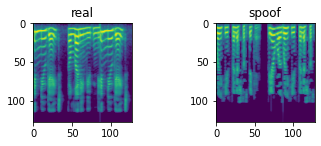

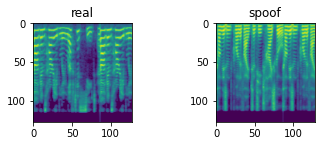

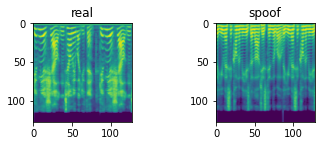

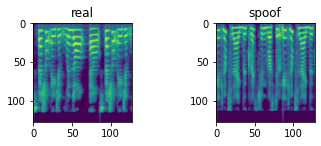

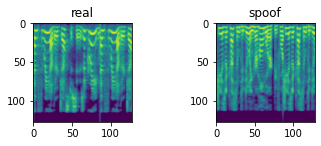

In [ ]:
#samples of the train data
for i in range(5):
    real_im = Image.open(df_train[df_train['class'] == '1'].iloc[i]['path'])
    spoof_im = Image.open(df_train[df_train['class'] == '0'].iloc[i]['path'])
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.title("real")
    plt.imshow(real_im)
    plt.subplot(2, 2, 2)
    plt.title("spoof")
    plt.imshow(spoof_im)

In [ ]:
#train data generator and validation generator. Used in Keras to feed data into model
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 width_shift_range=10,
                                 height_shift_range=10,
                                 zoom_range=0.2,
                                 shear_range = 0.2,
                                 horizontal_flip=False)

        
test_datagen=ImageDataGenerator(rescale=1./255.)
target_size = (128,128)

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train, directory=None , 
                                                  x_col="path", y_col='class',
                                                  target_size = target_size, class_mode="binary", 
                                                  drop_duplicates = False, shuffle = True,
                                                  color_mode = 'grayscale',
                                                  batch_size=64)


val_generator=test_datagen.flow_from_dataframe(dataframe=df_v, directory=None, 
                                                x_col="path", y_col='class', 
                                                target_size = target_size,class_mode="binary", 
                                                drop_duplicates = False, shuffle = True, 
                                                color_mode = 'grayscale',
                                                batch_size=64)

Found 23931 validated image filenames belonging to 2 classes.
Found 2826 validated image filenames belonging to 2 classes.


In [ ]:
#designing the model and model checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/DLProject',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



model = Sequential([
    Conv1D(256, 3, padding='same', activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv1D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv1D(256, 3, padding='same', activation='relu'),    
    MaxPooling2D(),
    Dropout(0.2),
    Conv1D(256, 3, padding='same', activation='relu'),    
    MaxPooling2D(),
    Dropout(0.2),
    Conv1D(256, 3, padding='same', activation='relu'),    
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 128, 256)     1024      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 64, 128)       98432     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

In [ ]:


hist = model.fit_generator(train_generator, epochs=100, steps_per_epoch = df_train.shape[0]// 64, 
                           validation_data=val_generator,validation_steps=df_v.shape[0] // 64,
                           callbacks = [ model_checkpoint_callback, er_stop])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
373/373 [==============================] - 3370s 9s/step - loss: 0.4235 - accuracy: 0.8091 - val_loss: 0.3193 - val_accuracy: 0.8757
Epoch 2/100
373/373 [==============================] - 86s 231ms/step - loss: 0.2629 - accuracy: 0.8778 - val_loss: 0.2447 - val_accuracy: 0.9212
Epoch 3/100
373/373 [==============================] - 86s 231ms/step - loss: 0.2343 - accuracy: 0.8923 - val_loss: 0.2502 - val_accuracy: 0.8935
Epoch 4/100
373/373 [==============================] - 86s 230ms/step - loss: 0.1886 - accuracy: 0.9191 - val_loss: 0.1745 - val_accuracy: 0.9332
Epoch 5/100
373/373 [==============================] - 86s 229ms/step - loss: 0.1754 - accuracy: 0.9234 - val_loss: 0.1955 - val_accuracy: 0.9279
Epoch 6/100
373/373 [==============================] - 86s 231ms/step - loss: 0.1596 - accuracy: 0.9325 - val_loss: 0.1553 - val_accuracy: 0.9513
Epoch 7/100
373/373 [==============================] - 86s 230ms/step - loss: 0.1421 - accuracy: 0.9403 - val_loss: 0.2493 - 

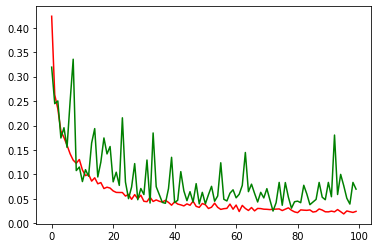

In [ ]:
#training loss and validation loss
plt.plot(hist.history['loss'], color = 'red')
plt.plot(hist.history['val_loss'], color = 'green')

In [ ]:
#prediction and accuracy results for the model

pred_generator=test_datagen.flow_from_dataframe(dataframe=df_v, directory=None, 
                                                x_col="path", y_col='class', 
                                                target_size = target_size,class_mode="binary", 
                                                drop_duplicates = False, shuffle = False, 
                                                color_mode = 'grayscale',
                                                batch_size=1)
model.load_weights('/content/drive/MyDrive/DLProject')

pred= model.predict_generator(pred_generator, steps=pred_generator.n//pred_generator.batch_size)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = df_v.to_numpy()
y_true = np.array(dtest[:,1:],dtype=int)

print(classification_report(y_true, y_pred))
print("confusion matrix:", '\n', confusion_matrix(y_true, y_pred))

Found 2826 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1826
           1       0.99      0.98      0.99      1000

    accuracy                           0.99      2826
   macro avg       0.99      0.99      0.99      2826
weighted avg       0.99      0.99      0.99      2826

confusion matrix: 
 [[1821    5]
 [  20  980]]


In [ ]:
#predicting on test set
path = '/content/drive/MyDrive/DLProject/Test'
tests = np.array([f for f in listdir(path) if isfile(join(path, f))])
df_t = pd.DataFrame()
df_t['path'] = tests
df_t['path'] = path + '/' + df_t['path'] 

In [ ]:
#obtaining mel spectogram images of the test set to perform prediction
audio_to_img(df_t, 'Test_data_image')

In [ ]:
#melspectrogram images
path = '/content/drive/MyDrive/DLProject/timg'
tests = np.array([f for f in listdir(path) if isfile(join(path, f))])
df_t = pd.DataFrame()
df_t['path'] = tests
df_t['path'] = path + '/' + df_t['path'] 

In [ ]:
#pred generator, used in keras https://newbedev.com/how-to-use-predict-generator-on-new-images-keras
pred_generator=test_datagen.flow_from_dataframe(dataframe=df_t, directory=None, 
                                                x_col="path", 
                                                class_mode = None,
                                                target_size = target_size,
                                                drop_duplicates = False, shuffle = False, 
                                                color_mode = 'grayscale',
                                                batch_size=1)

Found 959 validated image filenames.


In [ ]:
pred= model.predict_generator(pred_generator, steps=pred_generator.n//pred_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
path = '/content/drive/MyDrive/DLProject/Test'
tests = np.array([f for f in listdir(path) if isfile(join(path, f))])

In [ ]:
#results to txt and csv files
f = open('text_results.txt', 'w')
for name, confidence in zip(tests, pred):
    f.write(name + ', ' + str(confidence[0]) +'\n')
f.close()    

In [ ]:
cl = np.round(pred)
result = pd.DataFrame()
result['path'] = tests
result['confidence'] = pred
result ['class'] = cl[:,0]
result.to_csv('result.csv')